# Base

In [2]:
"""
Base Resnet
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import funcs
import jan
import coral
import star
import mcd
import dann
import base
import plots
import os
import seaborn as sns
import matplotlib.pyplot as plt
from torch.autograd import Function


class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        A basic residual block for 1D convolutions.
        """
        super(ResidualBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out

class DeepResNet(nn.Module):
    """
    A deep ResNet classifier for 1D signals.
    
    This network consists of:
      - An initial convolution + BN + ReLU + maxpool block.
      - Four residual layers (with increasing feature channels).
      - Global average pooling to obtain a fixed–length feature vector.
      - A bottleneck fully connected layer mapping to 512–dimensions.
      - A small classifier head (MLP) mapping to the desired output classes.
    """
    def __init__(self, output_dim=7):
        super(DeepResNet, self).__init__()
        # Initial convolutional block
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(in_channels=64, out_channels=64, blocks=2, stride=1)
        self.layer2 = self._make_layer(in_channels=64, out_channels=128, blocks=2, stride=2)
        self.layer3 = self._make_layer(in_channels=128, out_channels=256, blocks=2, stride=2)
        self.layer4 = self._make_layer(in_channels=256, out_channels=512, blocks=2, stride=2)
        
        # Global average pooling to obtain a fixed-length feature vector
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Bottleneck fully-connected layer: maps 512-dim to 512-dim features
        self.fc_bottleneck = nn.Linear(512, 512)
        
        # Classifier head (MLP)
        self.fc1 = nn.Linear(512, 256)
        self.bn_fc = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, output_dim)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        """
        Creates a sequential layer composed of multiple residual blocks.
        If the stride is not 1 or the number of channels change,
        a downsampling layer is used.
        """
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # x: (batch_size, 2, length)
        x = self.conv1(x)    # (B, 64, L/2)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # (B, 64, L/4)
        
        x = self.layer1(x)   # (B, 64, ?)
        x = self.layer2(x)   # (B, 128, ?)
        x = self.layer3(x)   # (B, 256, ?)
        x = self.layer4(x)   # (B, 512, ?)
        
        x = self.avgpool(x)  # (B, 512, 1)
        x = x.squeeze(-1)    # (B, 512)
        x = self.fc_bottleneck(x)  # (B, 512)
        
        # Classification head
        x = self.fc1(x)
        x = self.bn_fc(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes in loaded npy files
class_subset = ["bpsk", "qpsk", "16qam", "8apsk"]

# simulated data
X_sim = np.load(file_path + "/sim_X.npy")
Y_sim = np.load(file_path + "/sim_Y.npy")

# over the air data
X_ota = np.load(file_path + "/ota_X.npy")
Y_ota = np.load(file_path + "/ota_Y.npy")

z_val = 10
n_epochs = 50
lr = 0.001
n_runs = 5
n_snr = 4

# (Lists for storing accuracies; you may also want to add lists for deep coral)
t_deep_coral_acc = []
s_deep_coral_acc = []

for i in range(n_snr):
    print(f'\nSNR level: {z_val}')
    # Filter for SNR level (for simulated data)
    source_mask = (Y_sim[:, 1] == z_val)
    X_s = X_sim[source_mask]
    Y_s = Y_sim[source_mask]
    Y_s = Y_s[:, 0]  # first column: class labels

    # Filter for SNR level (for over the air data)
    source_mask = (Y_ota[:, 1] == z_val+4)
    X_t = X_ota[source_mask]
    Y_t = Y_ota[source_mask]
    Y_t = Y_t[:, 0]
    
    # Create data loaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, batch_size=128, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, batch_size=128, permute=False)

    print('Base')
    s_deep, t_deep = base.Base(
        model_cls=DeepResNet,
        device=device,
        S_train_loader=S_train_loader, 
        S_val_loader=S_val_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset, 
        n_classes=len(class_subset),
        lr=lr,
        n_epochs=n_epochs,
        n_runs=n_runs
    ).run()
    torch.cuda.empty_cache()
    s_deep_coral_acc.append(s_deep)
    t_deep_coral_acc.append(t_deep)

    z_val += 4

x = np.arange(1, n_snr+1)
print(len(t_deep_coral_acc))
print(len(x))

plt.figure(figsize=(10, 6))
#plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
#plt.plot(x, s_dann_acc, marker='v', linestyle='-', label='Source')
#plt.plot(x, t_dann_acc, marker='^', linestyle='-', label='Target')
#plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
#plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_deep_coral_acc, marker='v', linestyle='-', label='Target')
plt.plot(x, s_deep_coral_acc, marker='^', linestyle='-', label='Source')
#plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.legend()
plt.grid(True)
plt.show()


SNR level: 10
Base

Run 1/5
Epoch 1/50, Train Loss: 0.3343, Train Acc: 0.8866, Val Loss: 1.8476, Val Acc: 0.7350
Epoch 2/50, Train Loss: 0.0470, Train Acc: 0.9852, Val Loss: 0.8396, Val Acc: 0.8225
Epoch 3/50, Train Loss: 0.0246, Train Acc: 0.9930, Val Loss: 0.0628, Val Acc: 0.9790
Epoch 4/50, Train Loss: 0.0247, Train Acc: 0.9934, Val Loss: 0.0544, Val Acc: 0.9802
Epoch 5/50, Train Loss: 0.0100, Train Acc: 0.9973, Val Loss: 0.0636, Val Acc: 0.9772
Epoch 6/50, Train Loss: 0.0159, Train Acc: 0.9943, Val Loss: 0.0091, Val Acc: 0.9982
Epoch 7/50, Train Loss: 0.0058, Train Acc: 0.9993, Val Loss: 0.0204, Val Acc: 0.9946
Epoch 8/50, Train Loss: 0.0065, Train Acc: 0.9981, Val Loss: 0.0257, Val Acc: 0.9958
Epoch 9/50, Train Loss: 0.0131, Train Acc: 0.9957, Val Loss: 0.0280, Val Acc: 0.9928
Epoch 10/50, Train Loss: 0.0132, Train Acc: 0.9961, Val Loss: 0.4144, Val Acc: 0.8681
Epoch 11/50, Train Loss: 0.0058, Train Acc: 0.9984, Val Loss: 0.0029, Val Acc: 0.9994
Epoch 12/50, Train Loss: 0.0026, T

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3690, Train Acc: 0.8724, Val Loss: 2.3707, Val Acc: 0.3801
Epoch 2/50, Train Loss: 0.0589, Train Acc: 0.9778, Val Loss: 0.3930, Val Acc: 0.8813
Epoch 3/50, Train Loss: 0.0360, Train Acc: 0.9876, Val Loss: 0.8638, Val Acc: 0.7842
Epoch 4/50, Train Loss: 0.0176, Train Acc: 0.9942, Val Loss: 0.4042, Val Acc: 0.8735
Epoch 5/50, Train Loss: 0.0083, Train Acc: 0.9978, Val Loss: 0.0440, Val Acc: 0.9874
Epoch 6/50, Train Loss: 0.0058, Train Acc: 0.9982, Val Loss: 0.0102, Val Acc: 0.9958
Epoch 7/50, Train Loss: 0.0105, Train Acc: 0.9979, Val Loss: 0.0635, Val Acc: 0.9856
Epoch 8/50, Train Loss: 0.0170, Train Acc: 0.9939, Val Loss: 0.0684, Val Acc: 0.9772
Epoch 9/50, Train Loss: 0.0068, Train Acc: 0.9979, Val Loss: 0.0012, Val Acc: 1.0000
Epoch 10/50, Train Loss: 0.0059, Train Acc: 0.9982, Val Loss: 1.1403, Val Acc: 0.7314
Epoch 11/50, Train Loss: 0.0055, Train Acc: 0.9987, Val Loss: 0.0103, Val Acc: 0.9982
Epoch 12/50, Train Loss: 0.0015, Train Acc: 0.9999, Val Loss: 0

NameError: name 'plt' is not defined

4
4


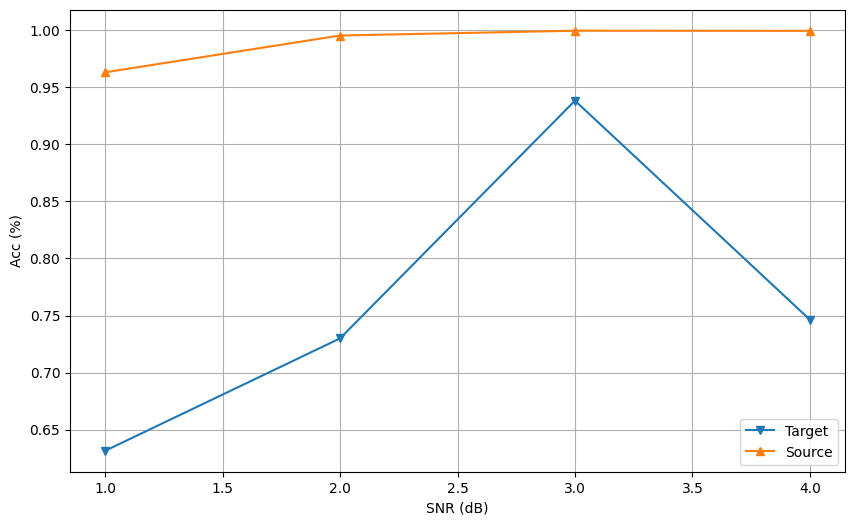

# DANN


SNR level: 10
DANN
Epoch 1/50, Loss: 2.1872, Domain Loss: 1.4106, Class Loss: 0.7766
Epoch 2/50, Loss: 1.5718, Domain Loss: 1.3709, Class Loss: 0.2010
Epoch 3/50, Loss: 1.4864, Domain Loss: 1.3698, Class Loss: 0.1166
Epoch 4/50, Loss: 1.4997, Domain Loss: 1.4132, Class Loss: 0.0865
Epoch 5/50, Loss: 1.9910, Domain Loss: 1.9179, Class Loss: 0.0730
Epoch 6/50, Loss: 5.8597, Domain Loss: 5.7182, Class Loss: 0.1415
Epoch 7/50, Loss: 7.5413, Domain Loss: 7.2215, Class Loss: 0.3198
Epoch 8/50, Loss: 9.1762, Domain Loss: 8.6722, Class Loss: 0.5040
Epoch 9/50, Loss: 7.8277, Domain Loss: 7.3547, Class Loss: 0.4730
Epoch 10/50, Loss: 6.9692, Domain Loss: 6.5206, Class Loss: 0.4486
Epoch 11/50, Loss: 3.3849, Domain Loss: 2.9559, Class Loss: 0.4290
Epoch 12/50, Loss: 3.7413, Domain Loss: 3.1723, Class Loss: 0.5690
Epoch 13/50, Loss: 2.6080, Domain Loss: 2.2828, Class Loss: 0.3252
Epoch 14/50, Loss: 2.3884, Domain Loss: 2.0647, Class Loss: 0.3236
Epoch 15/50, Loss: 2.0357, Domain Loss: 1.7551, Cla

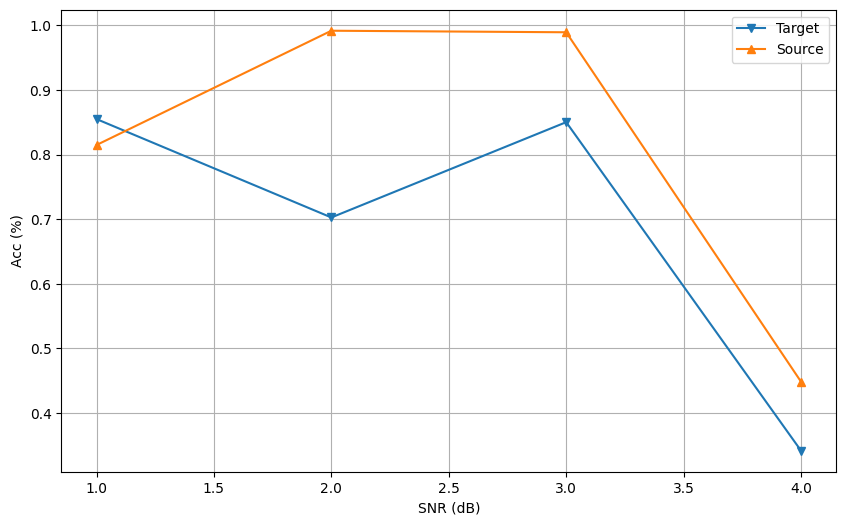

In [5]:
"""
Resnet for DANN.
"""
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import funcs
import jan
import coral
import star
import mcd
import dann
import base
import plots
import os
import seaborn as sns
import matplotlib.pyplot as plt
from torch.autograd import Function


class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

def grad_reverse(x, alpha=1.0):
    return ReverseLayerF.apply(x, alpha)
    
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        A basic residual block for 1D convolutions.
        """
        super(ResidualBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out

class DeepResNet_F(nn.Module):
    """
    Deep ResNet feature extractor for DANN.
    
    This network accepts a 2–channel 1D signal and outputs a 512–dimensional feature vector.
    """
    def __init__(self):
        super(DeepResNet_F, self).__init__()
        # Initial convolutional block
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(in_channels=64, out_channels=64, blocks=2, stride=1)
        self.layer2 = self._make_layer(in_channels=64, out_channels=128, blocks=2, stride=2)
        self.layer3 = self._make_layer(in_channels=128, out_channels=256, blocks=2, stride=2)
        self.layer4 = self._make_layer(in_channels=256, out_channels=512, blocks=2, stride=2)
        
        # Global average pooling to produce a fixed-length vector
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Bottleneck fully-connected layer (optional, here keeping feature dim at 512)
        self.fc_bottleneck = nn.Linear(512, 512)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        """
        Create a sequential layer composed of multiple residual blocks.
        """
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Input x: (batch_size, channels=2, length)
        x = self.conv1(x)    # -> (B, 64, L/2)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # -> (B, 64, L/4)
        
        x = self.layer1(x)   # -> (B, 64, ?)
        x = self.layer2(x)   # -> (B, 128, ?)
        x = self.layer3(x)   # -> (B, 256, ?)
        x = self.layer4(x)   # -> (B, 512, ?)
        
        # Global average pooling
        x = self.avgpool(x)  # -> (B, 512, 1)
        x = x.squeeze(-1)    # -> (B, 512)
        # Bottleneck transformation
        features = self.fc_bottleneck(x)  # (B, 512)
        return features

class DeepResNet_LP(nn.Module):
    """
    Label predictor network that maps 512–dim features to the desired output classes.
    """
    def __init__(self, output_dim=7):
        super(DeepResNet_LP, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class DeepResNet_DC(nn.Module):
    """
    Domain classifier network for DANN.
    
    This network applies a gradient reversal layer (using ReverseLayerF) to the feature vector
    before classifying it as either source or target.
    """
    def __init__(self):
        super(DeepResNet_DC, self).__init__()
        self.fc1 = nn.Linear(512, 100)
        self.fc2 = nn.Linear(100, 2)
        
    def forward(self, x, alpha):
        # Reverse gradient during the backward pass
        x = ReverseLayerF.apply(x, alpha)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes in loaded npy files
class_subset = ["bpsk", "qpsk", "16qam", "8apsk"]

# simulated data
X_sim = np.load(file_path + "/sim_X.npy")
Y_sim = np.load(file_path + "/sim_Y.npy")

# over the air data
X_ota = np.load(file_path + "/ota_X.npy")
Y_ota = np.load(file_path + "/ota_Y.npy")

z_val = 10
n_epochs = 50
lr = 0.001
n_runs = 5
n_snr = 4

# (Lists for storing accuracies; you may also want to add lists for deep coral)
t_deep_coral_acc = []
s_deep_coral_acc = []

for i in range(n_snr):
    print(f'\nSNR level: {z_val}')
    # Filter for SNR level (for simulated data)
    source_mask = (Y_sim[:, 1] == z_val)
    X_s = X_sim[source_mask]
    Y_s = Y_sim[source_mask]
    Y_s = Y_s[:, 0]  # first column: class labels

    # Filter for SNR level (for over the air data)
    source_mask = (Y_ota[:, 1] == z_val+4)
    X_t = X_ota[source_mask]
    Y_t = Y_ota[source_mask]
    Y_t = Y_t[:, 0]
    
    # Create data loaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, batch_size=128, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, batch_size=128, permute=False)

    print('DANN')
    s_deep, t_deep = dann.DAN(
        dann.DANN,
        FA=DeepResNet_F,
        LP=DeepResNet_LP,
        DC=DeepResNet_DC,
        device=device,
        S_train_loader=S_train_loader,
        S_val_loader=S_val_loader,
        T_train_loader=T_train_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset,
        n_classes=len(class_subset),
        lr=lr,
        n_epochs=n_epochs,
        n_runs=n_runs
    ).run()
    torch.cuda.empty_cache()
    s_deep_coral_acc.append(s_deep)
    t_deep_coral_acc.append(t_deep)

    z_val += 4

x = np.arange(1, n_snr+1)
print(len(t_deep_coral_acc))
print(len(x))

plt.figure(figsize=(10, 6))
#plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
#plt.plot(x, s_dann_acc, marker='v', linestyle='-', label='Source')
#plt.plot(x, t_dann_acc, marker='^', linestyle='-', label='Target')
#plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
#plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_deep_coral_acc, marker='v', linestyle='-', label='Target')
plt.plot(x, s_deep_coral_acc, marker='^', linestyle='-', label='Source')
#plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.legend()
plt.grid(True)
plt.show()

# Deep Coral


SNR level: 10
Deep CORAL
Deep CORAL Run 1/5
Epoch 1: Source Val Acc = 0.5510, Target Val Acc = 0.8237
Epoch 2: Source Val Acc = 0.9712, Target Val Acc = 0.7476
Epoch 3: Source Val Acc = 0.9862, Target Val Acc = 0.7272
Epoch 4: Source Val Acc = 0.7176, Target Val Acc = 0.5498
Epoch 5: Source Val Acc = 0.9658, Target Val Acc = 0.7560
Epoch 6: Source Val Acc = 0.6769, Target Val Acc = 0.6793
Epoch 7: Source Val Acc = 0.9706, Target Val Acc = 0.7764
Epoch 8: Source Val Acc = 0.9832, Target Val Acc = 0.8381
Early stopping triggered.
Run 1 finished: Best Source Val Acc = 0.9832, Target Val Acc = 0.8381

Deep CORAL Run 2/5
Epoch 1: Source Val Acc = 0.7326, Target Val Acc = 0.7530
Epoch 2: Source Val Acc = 0.9382, Target Val Acc = 0.7194
Epoch 3: Source Val Acc = 0.8225, Target Val Acc = 0.8873
Epoch 4: Source Val Acc = 0.7608, Target Val Acc = 0.9263
Epoch 5: Source Val Acc = 0.9898, Target Val Acc = 0.7800
Epoch 6: Source Val Acc = 0.9562, Target Val Acc = 0.8747
Epoch 7: Source Val Acc = 0

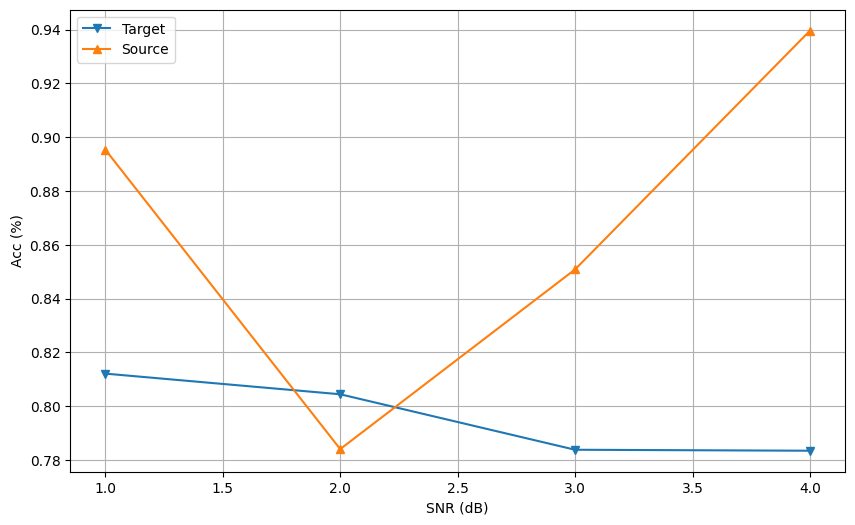

In [6]:
"""
Deep CORAL + ResNet.
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import funcs
import jan
import coral
import star
import mcd
import dann
import base
import plots
import os
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------
# Helper: CORAL loss function
# -------------------------
def coral_loss(source, target):
    """
    Computes the CORAL loss between two matrices.
    Assumes input tensors are of shape (batch_size, feature_dim).
    """
    d = source.size(1)
    ns = source.size(0)
    nt = target.size(0)
    # Center the features
    source_mean = torch.mean(source, dim=0, keepdim=True)
    target_mean = torch.mean(target, dim=0, keepdim=True)
    source_centered = source - source_mean
    target_centered = target - target_mean
    # Compute covariance matrices
    cov_source = (source_centered.t() @ source_centered) / (ns - 1)
    cov_target = (target_centered.t() @ target_centered) / (nt - 1)
    # Frobenius norm between covariance matrices (scaled)
    loss = torch.mean((cov_source - cov_target) ** 2)
    loss = loss / (4 * d * d)
    return loss

import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------
# Residual Block for 1D signals
# -------------------------
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        A basic residual block for 1D convolutions.
        """
        super(ResidualBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out

# -------------------------
# Deep ResNet Generator for Deep CORAL
# -------------------------
class DeepResNet_G(nn.Module):
    """
    Deep ResNet generator that extracts features at multiple depths for CORAL.
    
    Architecture:
      - An initial convolution + batchnorm + ReLU + maxpool.
      - Four layers (residual blocks) built with 1D convolutions.
      - Intermediate features are extracted after layer1 (early), layer2 (middle),
        and layer3 (late) via global average pooling.
      - The final layer (layer4) is pooled and passed through a fully-connected
        bottleneck to obtain a 512–dim feature for classification.
    """
    def __init__(self):
        super(DeepResNet_G, self).__init__()
        # Initial convolution layer
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(in_channels=64, out_channels=64, blocks=2, stride=1)
        self.layer2 = self._make_layer(in_channels=64, out_channels=128, blocks=2, stride=2)
        self.layer3 = self._make_layer(in_channels=128, out_channels=256, blocks=2, stride=2)
        self.layer4 = self._make_layer(in_channels=256, out_channels=512, blocks=2, stride=2)
        
        # Global average pooling (adaptive to any sequence length)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Bottleneck fully-connected layer mapping 512->512 for classification.
        self.fc_bottleneck = nn.Linear(512, 512)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        """
        Creates a sequential layer composed of multiple residual blocks.
        If the stride is not 1 or the channel dimensions differ,
        a downsampling layer is used.
        """
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Input x: (batch_size, channels=2, length)
        x = self.conv1(x)   # (B, 64, L/2)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x) # (B, 64, L/4)
        
        # Layer 1: Early features
        x1 = self.layer1(x)           # (B, 64, L1)
        early = self.avgpool(x1)      # (B, 64, 1)
        early = early.squeeze(-1)     # (B, 64)
        
        # Layer 2: Middle features
        x2 = self.layer2(x1)          # (B, 128, L2)
        middle = self.avgpool(x2)     # (B, 128, 1)
        middle = middle.squeeze(-1)   # (B, 128)
        
        # Layer 3: Late features for CORAL loss
        x3 = self.layer3(x2)          # (B, 256, L3)
        late = self.avgpool(x3)       # (B, 256, 1)
        late = late.squeeze(-1)       # (B, 256)
        
        # Layer 4: Final block for classification
        x4 = self.layer4(x3)          # (B, 512, L4)
        pooled = self.avgpool(x4)     # (B, 512, 1)
        pooled = pooled.squeeze(-1)   # (B, 512)
        final = self.fc_bottleneck(pooled)  # (B, 512)
        
        # Return multi-level features for deep CORAL
        return early, middle, late, final

# -------------------------
# Deep ResNet Classifier
# -------------------------
class ResNet_C(nn.Module):
    """
    Classifier network that maps the 512–dim bottleneck features to the output classes.
    
    Architecture:
      - A fully-connected layer (512 -> 256) with batch normalization, ReLU, and dropout.
      - A final fully-connected layer mapping 256 -> output_dim.
    """
    def __init__(self, output_dim):
        super(ResNet_C, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# -------------------------
# Deep CORAL Training Wrapper
# -------------------------
class DeepCORAL:
    def __init__(self, G, C, device, 
                 S_train_loader, S_val_loader, 
                 T_train_loader, T_val_loader,
                 class_subset, n_classes, lr, n_epochs, n_runs, patience, 
                 lambda_coral=0.5, deep_weights=(1.0, 1.0, 1.0)):
        """
        deep_weights: tuple of weights for the CORAL loss at (early, middle, late) layers.
        """
        self.G = G
        self.C = C
        self.device = device
        self.S_train_loader = S_train_loader
        self.S_val_loader = S_val_loader
        self.T_train_loader = T_train_loader
        self.T_val_loader = T_val_loader
        self.class_subset = class_subset
        self.n_classes = n_classes
        self.lr = lr
        self.n_epochs = n_epochs
        self.n_runs = n_runs
        self.patience = patience
        self.lambda_coral = lambda_coral
        self.deep_weights = deep_weights
        
    def evaluate(self, netG, netC, loader):
        netG.eval()
        netC.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, labels in loader:
                data, labels = data.to(self.device), labels.to(self.device)
                # Only need the classification branch (late_fc)
                _, _, _, cls_feat = netG(data)
                outputs = netC(cls_feat)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total

    def run(self):
        best_s_acc_list = []
        best_t_acc_list = []
        for run in range(self.n_runs):
            print(f"Deep CORAL Run {run+1}/{self.n_runs}")
            # Instantiate new networks for each run
            netG = self.G().to(self.device)
            netC = self.C(self.n_classes).to(self.device)
            optimizer = torch.optim.Adam(list(netG.parameters()) + list(netC.parameters()), lr=self.lr)
            criterion = nn.CrossEntropyLoss()
            best_val_acc = 0.0
            patience_counter = 0
            
            for epoch in range(self.n_epochs):
                netG.train()
                netC.train()
                # Use zip to iterate over source and target batches in parallel.
                for (s_data, s_labels), (t_data, _) in zip(self.S_train_loader, self.T_train_loader):
                    s_data, s_labels = s_data.to(self.device), s_labels.to(self.device)
                    t_data = t_data.to(self.device)
                    
                    # Forward pass for source: get all features
                    s_early, s_middle, s_late, s_cls = netG(s_data)
                    # Classification loss on source (using the classification feature)
                    loss_cls = criterion(netC(s_cls), s_labels)
                    
                    # Forward pass for target: we only need the intermediate features
                    t_early, t_middle, t_late, _ = netG(t_data)
                    
                    # Compute CORAL loss for each level
                    loss_early = coral_loss(s_early, t_early)
                    loss_middle = coral_loss(s_middle, t_middle)
                    loss_late = coral_loss(s_late, t_late)
                    loss_coral_total = (self.deep_weights[0] * loss_early +
                                        self.deep_weights[1] * loss_middle +
                                        self.deep_weights[2] * loss_late)
                    
                    total_loss = loss_cls + self.lambda_coral * loss_coral_total
                    
                    optimizer.zero_grad()
                    total_loss.backward()
                    optimizer.step()
                    
                # End-of-epoch evaluation on source validation set
                s_acc = self.evaluate(netG, netC, self.S_val_loader)
                t_acc = self.evaluate(netG, netC, self.T_val_loader)
                print(f"Epoch {epoch+1}: Source Val Acc = {s_acc:.4f}, Target Val Acc = {t_acc:.4f}")
                
                # Early stopping on source validation accuracy
                if s_acc > best_val_acc:
                    best_val_acc = s_acc
                    best_model_G = netG.state_dict()
                    best_model_C = netC.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                if patience_counter >= self.patience:
                    print("Early stopping triggered.")
                    break
                    
            # Load best model from this run
            netG.load_state_dict(best_model_G)
            netC.load_state_dict(best_model_C)
            s_acc = self.evaluate(netG, netC, self.S_val_loader)
            t_acc = self.evaluate(netG, netC, self.T_val_loader)
            print(f"Run {run+1} finished: Best Source Val Acc = {s_acc:.4f}, Target Val Acc = {t_acc:.4f}\n")
            best_s_acc_list.append(s_acc)
            best_t_acc_list.append(t_acc)
            
        avg_s_acc = np.mean(best_s_acc_list)
        avg_t_acc = np.mean(best_t_acc_list)
        print(f"Deep CORAL: Average Source Val Acc = {avg_s_acc:.4f}, Average Target Val Acc = {avg_t_acc:.4f}")
        return avg_s_acc, avg_t_acc

# -------------------------
# Data loading (same as before)
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes in loaded npy files
class_subset = ["bpsk", "qpsk", "16qam", "8apsk"]

# simulated data
X_sim = np.load(file_path + "/sim_X.npy")
Y_sim = np.load(file_path + "/sim_Y.npy")

# over the air data
X_ota = np.load(file_path + "/ota_X.npy")
Y_ota = np.load(file_path + "/ota_Y.npy")

z_val = 10
n_epochs = 50
lr = 0.001
n_runs = 5
n_snr = 4

# (Lists for storing accuracies; you may also want to add lists for deep coral)
t_deep_coral_acc = []
s_deep_coral_acc = []

for i in range(n_snr):
    print(f'\nSNR level: {z_val}')
    # Filter for SNR level (for simulated data)
    source_mask = (Y_sim[:, 1] == z_val)
    X_s = X_sim[source_mask]
    Y_s = Y_sim[source_mask]
    Y_s = Y_s[:, 0]  # first column: class labels

    # Filter for SNR level (for over the air data)
    source_mask = (Y_ota[:, 1] == z_val+4)
    X_t = X_ota[source_mask]
    Y_t = Y_ota[source_mask]
    Y_t = Y_t[:, 0]
    
    # Create data loaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, batch_size=128, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, batch_size=128, permute=False)

    print('Deep CORAL')
    s_deep, t_deep = DeepCORAL(
        G=DeepResNet_G, 
        C=ResNet_C, 
        device=device, 
        S_train_loader=S_train_loader,
        S_val_loader=S_val_loader,
        T_train_loader=T_train_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset,
        n_classes=len(class_subset),
        lr=lr, 
        n_epochs=n_epochs, 
        n_runs=n_runs,
        patience=5,
        lambda_coral=0.5,
        deep_weights=(1.0, 1.0, 1.0)
    ).run()
    torch.cuda.empty_cache()
    s_deep_coral_acc.append(s_deep)
    t_deep_coral_acc.append(t_deep)

    z_val += 4

x = np.arange(1, n_snr+1)
print(len(t_deep_coral_acc))
print(len(x))

plt.figure(figsize=(10, 6))
#plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
#plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
#plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
#plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_deep_coral_acc, marker='v', linestyle='-', label='Target')
plt.plot(x, s_deep_coral_acc, marker='^', linestyle='-', label='Source')
#plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.legend()
plt.grid(True)
plt.show()

# STAR

In [ ]:
"""
STAR + ResNet.
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import funcs
import jan
import coral
import star
import mcd
import dann
import base
import plots
import os
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F


# -------------------------
# Residual Block for 1D signals
# -------------------------
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        A basic residual block for 1D convolutions.
        """
        super(ResidualBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out

# -------------------------
# Deep ResNet Generator for STAR (DeepResNet_STAR_G)
# -------------------------
class DeepResNet_STAR_G(nn.Module):
    """
    Deep ResNet feature extractor for STAR.
    
    This network accepts a 2–channel 1D signal and extracts a 512–dimensional
    feature vector via several residual layers.
    """
    def __init__(self):
        super(DeepResNet_STAR_G, self).__init__()
        # Initial convolutional block
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)
        
        # Global average pooling to obtain a fixed-length feature vector
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Optional bottleneck fully-connected layer (maps 512->512)
        self.fc_bottleneck = nn.Linear(512, 512)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # x: (batch_size, channels=2, length)
        x = self.conv1(x)      # (B, 64, L/2)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)    # (B, 64, L/4)
        
        x = self.layer1(x)     # (B, 64, ?)
        x = self.layer2(x)     # (B, 128, ?)
        x = self.layer3(x)     # (B, 256, ?)
        x = self.layer4(x)     # (B, 512, ?)
        
        x = self.avgpool(x)    # (B, 512, 1)
        x = x.squeeze(-1)      # (B, 512)
        x = self.fc_bottleneck(x)  # (B, 512)
        return x

# -------------------------
# Deep ResNet Stochastic Classifier for STAR (DeepResNet_STAR_C)
# -------------------------
class DeepResNet_STAR_C(nn.Module):
    """
    Stochastic classifier network for STAR.
    
    This network receives the 512–dim features from DeepResNet_STAR_G,
    applies a fully connected layer with batch normalization and ReLU,
    and then uses a learned weight distribution (mu2, sigma2) to sample
    classifier weights. During training, it samples num_classifiers_train classifiers,
    while during evaluation it can either use only the mean (only_mu=True) or
    sample num_classifiers_test classifiers.
    """
    def __init__(self, output_dim, num_classifiers_train=2, num_classifiers_test=20,
                 init='kaiming_u', use_init=False):
        super(DeepResNet_STAR_C, self).__init__()
        self.num_classifiers_train = num_classifiers_train
        self.num_classifiers_test = num_classifiers_test
        self.init = init

        function_init = {
            'kaiming_u': nn.init.kaiming_uniform_,
            'kaiming_n': nn.init.kaiming_normal_,
            'xavier': nn.init.xavier_normal_
        }

        # Change input dimension to 512 (from the DeepResNet feature extractor)
        self.fc1 = nn.Linear(512, 128)
        self.bn1_fc = nn.BatchNorm1d(128)

        # Learnable parameters for the classifier weight distribution
        self.mu2 = nn.Parameter(torch.randn(output_dim, 128))
        self.sigma2 = nn.Parameter(torch.zeros(output_dim, 128))

        if use_init:
            for item in [self.mu2, self.sigma2]:
                function_init[self.init](item)

        self.b2 = nn.Parameter(torch.zeros(output_dim))

    def forward(self, x, only_mu=True):
        x = self.fc1(x)
        x = F.relu(self.bn1_fc(x))

        sigma2_pos = torch.sigmoid(self.sigma2)
        fc2_distribution = torch.distributions.Normal(self.mu2, sigma2_pos)

        if self.training:
            classifiers = []
            for _ in range(self.num_classifiers_train):
                fc2_w = fc2_distribution.rsample()
                classifiers.append([fc2_w, self.b2])

            outputs = []
            for classifier in classifiers:
                out = F.linear(x, classifier[0], classifier[1])
                outputs.append(out)
            return outputs
        else:
            if only_mu:
                out = F.linear(x, self.mu2, self.b2)
                return [out]
            else:
                classifiers = []
                for _ in range(self.num_classifiers_test):
                    fc2_w = fc2_distribution.rsample()
                    classifiers.append([fc2_w, self.b2])
                outputs = []
                for classifier in classifiers:
                    out = F.linear(x, classifier[0], classifier[1])
                    outputs.append(out)
                return outputs


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes in loaded npy files
class_subset = ["bpsk", "qpsk", "16qam", "8apsk"]

# simulated data
X_sim = np.load(file_path + "/sim_X.npy")
Y_sim = np.load(file_path + "/sim_Y.npy")

# over the air data
X_ota = np.load(file_path + "/ota_X.npy")
Y_ota = np.load(file_path + "/ota_Y.npy")

z_val = 10
n_epochs = 50
lr = 0.001
n_runs = 5
n_snr = 4

# (Lists for storing accuracies; you may also want to add lists for deep coral)
t_deep_coral_acc = []
s_deep_coral_acc = []

for i in range(n_snr):
    print(f'\nSNR level: {z_val}')
    # Filter for SNR level (for simulated data)
    source_mask = (Y_sim[:, 1] == z_val)
    X_s = X_sim[source_mask]
    Y_s = Y_sim[source_mask]
    Y_s = Y_s[:, 0]  # first column: class labels

    # Filter for SNR level (for over the air data)
    source_mask = (Y_ota[:, 1] == z_val+4)
    X_t = X_ota[source_mask]
    Y_t = Y_ota[source_mask]
    Y_t = Y_t[:, 0]
    
    # Create data loaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, batch_size=128, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, batch_size=128, permute=False)

    print('STAR')
    s_deep, t_deep =  star.Star(
        G=DeepResNet_STAR_G,
        C=DeepResNet_STAR_C,
        device=device,
        S_train_loader=S_train_loader,
        S_val_loader=S_val_loader,  
        T_train_loader=T_train_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset,
        n_classes=len(class_subset),
        lr=lr,
        n_epochs=n_epochs,
        n_runs=n_runs,
        patience=5
    ).run()
    torch.cuda.empty_cache()
    s_deep_coral_acc.append(s_deep)
    t_deep_coral_acc.append(t_deep)

    z_val += 4

x = np.arange(1, n_snr+1)
print(len(t_deep_coral_acc))
print(len(x))

plt.figure(figsize=(10, 6))
#plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
#plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
#plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
#plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_deep_coral_acc, marker='v', linestyle='-', label='Target')
plt.plot(x, s_deep_coral_acc, marker='^', linestyle='-', label='Source')
#plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.legend()
plt.grid(True)
plt.show()


SNR level: 10
Deep CORAL

Run 1/5
Epoch [1/50], Class Loss: 0.9895, Discrepancy Loss: 0.0756
Epoch [2/50], Class Loss: 0.3909, Discrepancy Loss: 0.0527
Epoch [3/50], Class Loss: 0.1956, Discrepancy Loss: 0.0274
Epoch [4/50], Class Loss: 0.3188, Discrepancy Loss: 0.0306
Epoch [5/50], Class Loss: 0.1588, Discrepancy Loss: 0.0293
Epoch [6/50], Class Loss: 0.0530, Discrepancy Loss: 0.0189
Epoch [7/50], Class Loss: 0.0395, Discrepancy Loss: 0.0126
Epoch [8/50], Class Loss: 0.0424, Discrepancy Loss: 0.0132
Epoch [9/50], Class Loss: 0.2177, Discrepancy Loss: 0.0252
Epoch [10/50], Class Loss: 0.2657, Discrepancy Loss: 0.0334
Epoch [11/50], Class Loss: 0.0298, Discrepancy Loss: 0.0157
Epoch [12/50], Class Loss: 0.1721, Discrepancy Loss: 0.0130
Epoch [13/50], Class Loss: 0.0362, Discrepancy Loss: 0.0203
Epoch [14/50], Class Loss: 0.1449, Discrepancy Loss: 0.0157
Epoch [15/50], Class Loss: 0.0303, Discrepancy Loss: 0.0215
Epoch [16/50], Class Loss: 0.0252, Discrepancy Loss: 0.0153
Epoch [17/50],

# MCD


SNR level: 10
Deep CORAL

Run 1/5
Epoch [1/50], Class Loss: 0.8592, Discrepancy Loss: 0.0249
Validation Loss: 4.1149
Epoch [2/50], Class Loss: 0.2731, Discrepancy Loss: 0.0077
Validation Loss: 4.1813
Epoch [3/50], Class Loss: 0.1028, Discrepancy Loss: 0.0063
Validation Loss: 0.3569
Epoch [4/50], Class Loss: 0.0791, Discrepancy Loss: 0.0083
Validation Loss: 3.0246
Epoch [5/50], Class Loss: 0.1476, Discrepancy Loss: 0.0138
Validation Loss: 6.2477
Epoch [6/50], Class Loss: 0.0446, Discrepancy Loss: 0.0074
Validation Loss: 0.0561
Epoch [7/50], Class Loss: 0.0856, Discrepancy Loss: 0.0116
Validation Loss: 0.0279
Epoch [8/50], Class Loss: 0.0849, Discrepancy Loss: 0.0093
Validation Loss: 2.6451
Epoch [9/50], Class Loss: 0.0429, Discrepancy Loss: 0.0066
Validation Loss: 0.0344
Epoch [10/50], Class Loss: 0.0264, Discrepancy Loss: 0.0113
Validation Loss: 0.0442
Epoch [11/50], Class Loss: 0.0114, Discrepancy Loss: 0.0060
Validation Loss: 0.0141
Epoch [12/50], Class Loss: 0.0020, Discrepancy Los

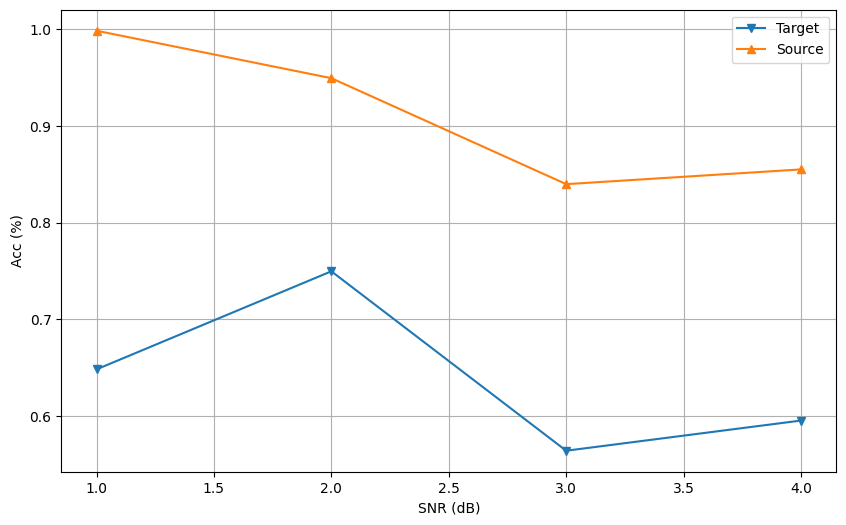

In [1]:
"""
Resnet for MCD
"""
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import funcs
import jan
import coral
import star
import mcd
import dann
import base
import plots
import os
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lambda_=1.0):
    return GradReverse.apply(x, lambda_)


class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        A basic residual block for 1D convolutions.
        """
        super(ResidualBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out
        
class DeepResNet_MCD_G(nn.Module):
    def __init__(self):
        super(DeepResNet_MCD_G, self).__init__()
        # Initial convolutional block
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(in_channels=64, out_channels=64, blocks=2, stride=1)
        self.layer2 = self._make_layer(in_channels=64, out_channels=128, blocks=2, stride=2)
        self.layer3 = self._make_layer(in_channels=128, out_channels=256, blocks=2, stride=2)
        self.layer4 = self._make_layer(in_channels=256, out_channels=512, blocks=2, stride=2)
        
        # Global average pooling to get a fixed-length feature vector
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Bottleneck fully-connected layer mapping 512 -> 512 (optional)
        self.fc_bottleneck = nn.Linear(512, 512)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Input x shape: (batch_size, 2, length)
        x = self.conv1(x)      # -> (B, 64, L/2)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)    # -> (B, 64, L/4)
        
        x = self.layer1(x)     # -> (B, 64, ?)
        x = self.layer2(x)     # -> (B, 128, ?)
        x = self.layer3(x)     # -> (B, 256, ?)
        x = self.layer4(x)     # -> (B, 512, ?)
        
        x = self.avgpool(x)    # -> (B, 512, 1)
        x = x.squeeze(-1)      # -> (B, 512)
        x = self.fc_bottleneck(x)  # -> (B, 512)
        return x

class DeepResNet_MCD_C(nn.Module):
    def __init__(self, output_dim):
        super(DeepResNet_MCD_C, self).__init__()
        # Since our feature extractor now outputs a 512-dim vector,
        # adjust the input dimension accordingly.
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, x, reverse=False, lambda_=1.0):
        # Optionally apply gradient reversal
        if reverse:
            x = grad_reverse(x, lambda_)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes in loaded npy files
class_subset = ["bpsk", "qpsk", "16qam", "8apsk"]

# simulated data
X_sim = np.load(file_path + "/sim_X.npy")
Y_sim = np.load(file_path + "/sim_Y.npy")

# over the air data
X_ota = np.load(file_path + "/ota_X.npy")
Y_ota = np.load(file_path + "/ota_Y.npy")

z_val = 10
n_epochs = 50
lr = 0.001
n_runs = 5
n_snr = 4

# (Lists for storing accuracies; you may also want to add lists for deep coral)
t_deep_coral_acc = []
s_deep_coral_acc = []

for i in range(n_snr):
    print(f'\nSNR level: {z_val}')
    # Filter for SNR level (for simulated data)
    source_mask = (Y_sim[:, 1] == z_val)
    X_s = X_sim[source_mask]
    Y_s = Y_sim[source_mask]
    Y_s = Y_s[:, 0]  # first column: class labels

    # Filter for SNR level (for over the air data)
    source_mask = (Y_ota[:, 1] == z_val+4)
    X_t = X_ota[source_mask]
    Y_t = Y_ota[source_mask]
    Y_t = Y_t[:, 0]
    
    # Create data loaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, batch_size=128, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, batch_size=128, permute=False)

    print('MCD')
    s_deep, t_deep = mcd.Mcd(
        G=DeepResNet_MCD_G,
        C=DeepResNet_MCD_C,
        device=device,
        S_train_loader=S_train_loader,
        S_val_loader=S_val_loader,  
        T_train_loader=T_train_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset,
        n_classes=len(class_subset),
        lr=lr,
        n_epochs=50,
        n_runs=n_runs,
        patience=5
    ).run()
    torch.cuda.empty_cache()
    s_deep_coral_acc.append(s_deep)
    t_deep_coral_acc.append(t_deep)

    z_val += 4

x = np.arange(1, n_snr+1)
print(len(t_deep_coral_acc))
print(len(x))

plt.figure(figsize=(10, 6))
#plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
#plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
#plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
#plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_deep_coral_acc, marker='v', linestyle='-', label='Target')
plt.plot(x, s_deep_coral_acc, marker='^', linestyle='-', label='Source')
#plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.legend()
plt.grid(True)
plt.show()

# JAN


SNR level: 10
Deep CORAL

Run 1/5
Epoch [1/50], Class Loss: 0.3859, JMMD Loss: 0.0887
Validation Loss: 2.4746
Epoch [2/50], Class Loss: 0.0874, JMMD Loss: 0.0785
Validation Loss: 0.5114
Epoch [3/50], Class Loss: 0.0809, JMMD Loss: 0.0768
Validation Loss: 0.2649
Epoch [4/50], Class Loss: 0.0198, JMMD Loss: 0.0679
Validation Loss: 0.0942
Epoch [5/50], Class Loss: 0.0308, JMMD Loss: 0.0810
Validation Loss: 0.4649
Epoch [6/50], Class Loss: 0.1232, JMMD Loss: 0.0862
Validation Loss: 1.4683
Epoch [7/50], Class Loss: 0.0772, JMMD Loss: 0.0808
Validation Loss: 0.0534
Epoch [8/50], Class Loss: 0.0215, JMMD Loss: 0.0735
Validation Loss: 0.6228
Epoch [9/50], Class Loss: 0.0067, JMMD Loss: 0.0742
Validation Loss: 0.1445
Epoch [10/50], Class Loss: 0.0271, JMMD Loss: 0.0689
Validation Loss: 0.3923
Epoch [11/50], Class Loss: 0.0131, JMMD Loss: 0.0659
Validation Loss: 0.0386
Epoch [12/50], Class Loss: 0.0070, JMMD Loss: 0.0587
Validation Loss: 0.0426
Epoch [13/50], Class Loss: 0.0058, JMMD Loss: 0.06

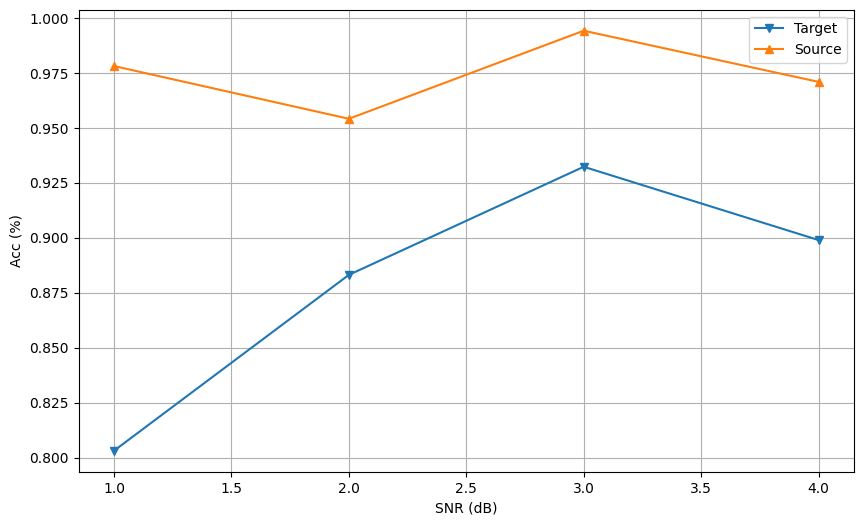

In [4]:
"""
Resnet for JAN
"""
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import funcs
import jan
import coral
import star
import mcd
import dann
import base
import plots
import os
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F


import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------
# Residual Block for 1D signals
# -------------------------
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        A basic residual block for 1D convolutions.
        """
        super(ResidualBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

# -------------------------
# Deep ResNet Generator for JAN
# -------------------------
class DeepResNet_JAN_G(nn.Module):
    def __init__(self):
        super(DeepResNet_JAN_G, self).__init__()
        # Initial convolutional block
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)
        
        # Global average pooling to obtain a fixed-length feature vector
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Bottleneck layer mapping 512 -> 512 dimensions
        self.fc_bottleneck = nn.Linear(512, 512)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # x: (batch_size, 2, length)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)  # shape: (batch, 512, 1)
        x = x.squeeze(-1)    # shape: (batch, 512)
        x = self.fc_bottleneck(x)  # shape: (batch, 512)
        
        # Debug: Ensure x is a valid tensor
        if x is None:
            raise ValueError("Generator output is None. Check your forward pass.")
        # You can also uncomment the next line to print the shape during debugging.
        # print("Generator output shape:", x.shape)
        return x

# -------------------------
# Deep ResNet Classifier for JAN
# -------------------------
class DeepResNet_C_JAN(nn.Module):
    def __init__(self, output_dim):
        super(DeepResNet_C_JAN, self).__init__()
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, output_dim)
        
    def forward(self, x, return_intermediate=False):
        inter = torch.relu(self.fc1(x))
        out = self.fc2(inter)
        if return_intermediate:
            return out, inter
        else:
            return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes in loaded npy files
class_subset = ["bpsk", "qpsk", "16qam", "8apsk"]

# simulated data
X_sim = np.load(file_path + "/sim_X.npy")
Y_sim = np.load(file_path + "/sim_Y.npy")

# over the air data
X_ota = np.load(file_path + "/ota_X.npy")
Y_ota = np.load(file_path + "/ota_Y.npy")

z_val = 10
n_epochs = 50
lr = 0.001
n_runs = 5
n_snr = 4

# (Lists for storing accuracies; you may also want to add lists for deep coral)
t_deep_coral_acc = []
s_deep_coral_acc = []

for i in range(n_snr):
    print(f'\nSNR level: {z_val}')
    # Filter for SNR level (for simulated data)
    source_mask = (Y_sim[:, 1] == z_val)
    X_s = X_sim[source_mask]
    Y_s = Y_sim[source_mask]
    Y_s = Y_s[:, 0]  # first column: class labels

    # Filter for SNR level (for over the air data)
    source_mask = (Y_ota[:, 1] == z_val+4)
    X_t = X_ota[source_mask]
    Y_t = Y_ota[source_mask]
    Y_t = Y_t[:, 0]
    
    # Create data loaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, batch_size=128, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, batch_size=128, permute=False)

    print('JAN')
    s_deep, t_deep = jan.Jan(
        C=DeepResNet_C_JAN,
        G=DeepResNet_JAN_G,
        num_classes=len(class_subset),
        device=device,
        S_train_loader=S_train_loader,
        T_train_loader=T_train_loader,
        S_val_loader=S_val_loader,
        T_val_loader=T_val_loader,
        n_epochs=n_epochs,
        lr=lr,
        lambda_jmmd=0.1,
        n_runs=n_runs
    ).run()
    torch.cuda.empty_cache()
    s_deep_coral_acc.append(s_deep)
    t_deep_coral_acc.append(t_deep)

    z_val += 4

x = np.arange(1, n_snr+1)
print(len(t_deep_coral_acc))
print(len(x))

plt.figure(figsize=(10, 6))
#plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
#plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
#plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
#plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_deep_coral_acc, marker='v', linestyle='-', label='Target')
plt.plot(x, s_deep_coral_acc, marker='^', linestyle='-', label='Source')
#plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.legend()
plt.grid(True)
plt.show()